<a href="https://colab.research.google.com/github/andrewRowlinson/data-science/blob/master/football/outliers_movers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplsoccer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from mplsoccer import Sbopen, Pitch

parser = Sbopen()
pitch = Pitch(line_zorder=2)

In [3]:
# first let's get the match file which lists all the match identifiers for
# the games in the Euros
df_match = parser.match(competition_id=53, season_id=106)
match_ids = df_match.match_id.unique()

# next we create a dataframe of all the events
all_events_df = []
set_pieces = ['Throw-in', 'Free Kick', 'Goal Kick', 'Corner', 'Kick Off', 'Penalty']
cols = ['match_id', 'id', 'type_name', 'sub_type_name', 'player_name',
        'x', 'y', 'end_x', 'end_y', 'outcome_name']
for match_id in match_ids:
    # get carries/ passes/ shots
    event = parser.event(match_id)[0]  # get the first dataframe (events) which has index = 0
    event = event.loc[((event.type_name.isin(['Carry', 'Pass'])) &
                       (~event['sub_type_name'].isin(set_pieces))),  # remove set-piece events
                      cols].copy()

    # boolean columns for working out probabilities
    event['goal'] = event['outcome_name'] == 'Goal'
    event['shoot'] = event['type_name'] == 'Shot'
    event['move'] = event['type_name'] != 'Shot'
    all_events_df.append(event)
event = pd.concat(all_events_df)

In [4]:
event.match_id.nunique()

31

In [5]:
event.type_name.value_counts()

Pass     26155
Carry    22749
Name: type_name, dtype: int64

In [6]:
event.player_name.value_counts().describe()

count    308.000000
mean     158.779221
std      149.773042
min        1.000000
25%       50.750000
50%      124.000000
75%      216.750000
max      930.000000
Name: player_name, dtype: float64

Filter for players with 50 or more successful movements

In [7]:
player_count = event.player_name.value_counts()

In [8]:
players = player_count[player_count >= 50].index.tolist()

In [9]:
# filter players with 50+ movements and successful 
event= event[(event.player_name.isin(players)) &
             (event.outcome_name.isnull())].reset_index(drop=True).copy()

Bin the data start and end locations for the movements. Along with the player name and a numerical version (0-n players)

In [10]:
pitch = Pitch()

In [11]:
bins = (pitch.dim.positional_x[[0, 3, 4, 5, 6]], pitch.dim.positional_y)

In [12]:
bin_start_locations = pitch.bin_statistic(event['x'], event['y'], bins=bins)

In [13]:
bin_end_locations = pitch.bin_statistic(event['end_x'], event['end_y'], bins=bins)

In [14]:
event['player_code'] = event.player_name.astype('category').cat.codes

In [15]:
df_bin = pd.DataFrame({'player_name': event.player_name,
                       'player_code': event.player_code,
                       'x': bin_start_locations['binnumber'][0],
                       'y': bin_start_locations['binnumber'][1],
                       'end_x': bin_end_locations['binnumber'][0],
                       'end_y': bin_end_locations['binnumber'][1]})

Turn this into a move transition matrix. Where for each player we get the percentages of movements between grid cells (400 in total)

In [16]:
bin_counts = df_bin.value_counts().reset_index(name='bin_counts')

In [17]:
num_y, num_x = bin_start_locations['statistic'].shape
move_transition_matrix = np.zeros((event.player_code.max() + 1, num_y, num_x, num_y, num_x))

In [18]:
move_transition_matrix[bin_counts['player_code'], bin_counts['y'], bin_counts['x'],                       bin_counts['end_y'], bin_counts['end_x']] = bin_counts.bin_counts.values

In [19]:
move_transition_matrix.sum()

41558.0

In [20]:
len(event)

41558

In [21]:
player_transitions = pd.DataFrame(move_transition_matrix.reshape(move_transition_matrix.shape[0], -1))

In [22]:
event['player_code'] = event.player_name.astype('category').cat.codes

In [23]:
code_mapping = event[['player_code', 'player_name']].drop_duplicates().set_index('player_code').to_dict()['player_name']

In [24]:
player_transitions['player_name'] = player_transitions.index.map(code_mapping)

In [25]:
player_transitions = player_transitions.set_index('player_name')

In [26]:
player_transitions = player_transitions.divide(player_transitions.sum(axis='columns'), axis='rows')

Run isolation forests on the move transitions to find outliers for movements between the grid cells

In [27]:
clf = IsolationForest(random_state=42, contamination=0.1)
y_pred = clf.fit(player_transitions)
player_transitions['forest_score'] = clf.score_samples(player_transitions)

In [28]:
player_transitions.sort_values('forest_score', inplace=True)

Top 12 outliers

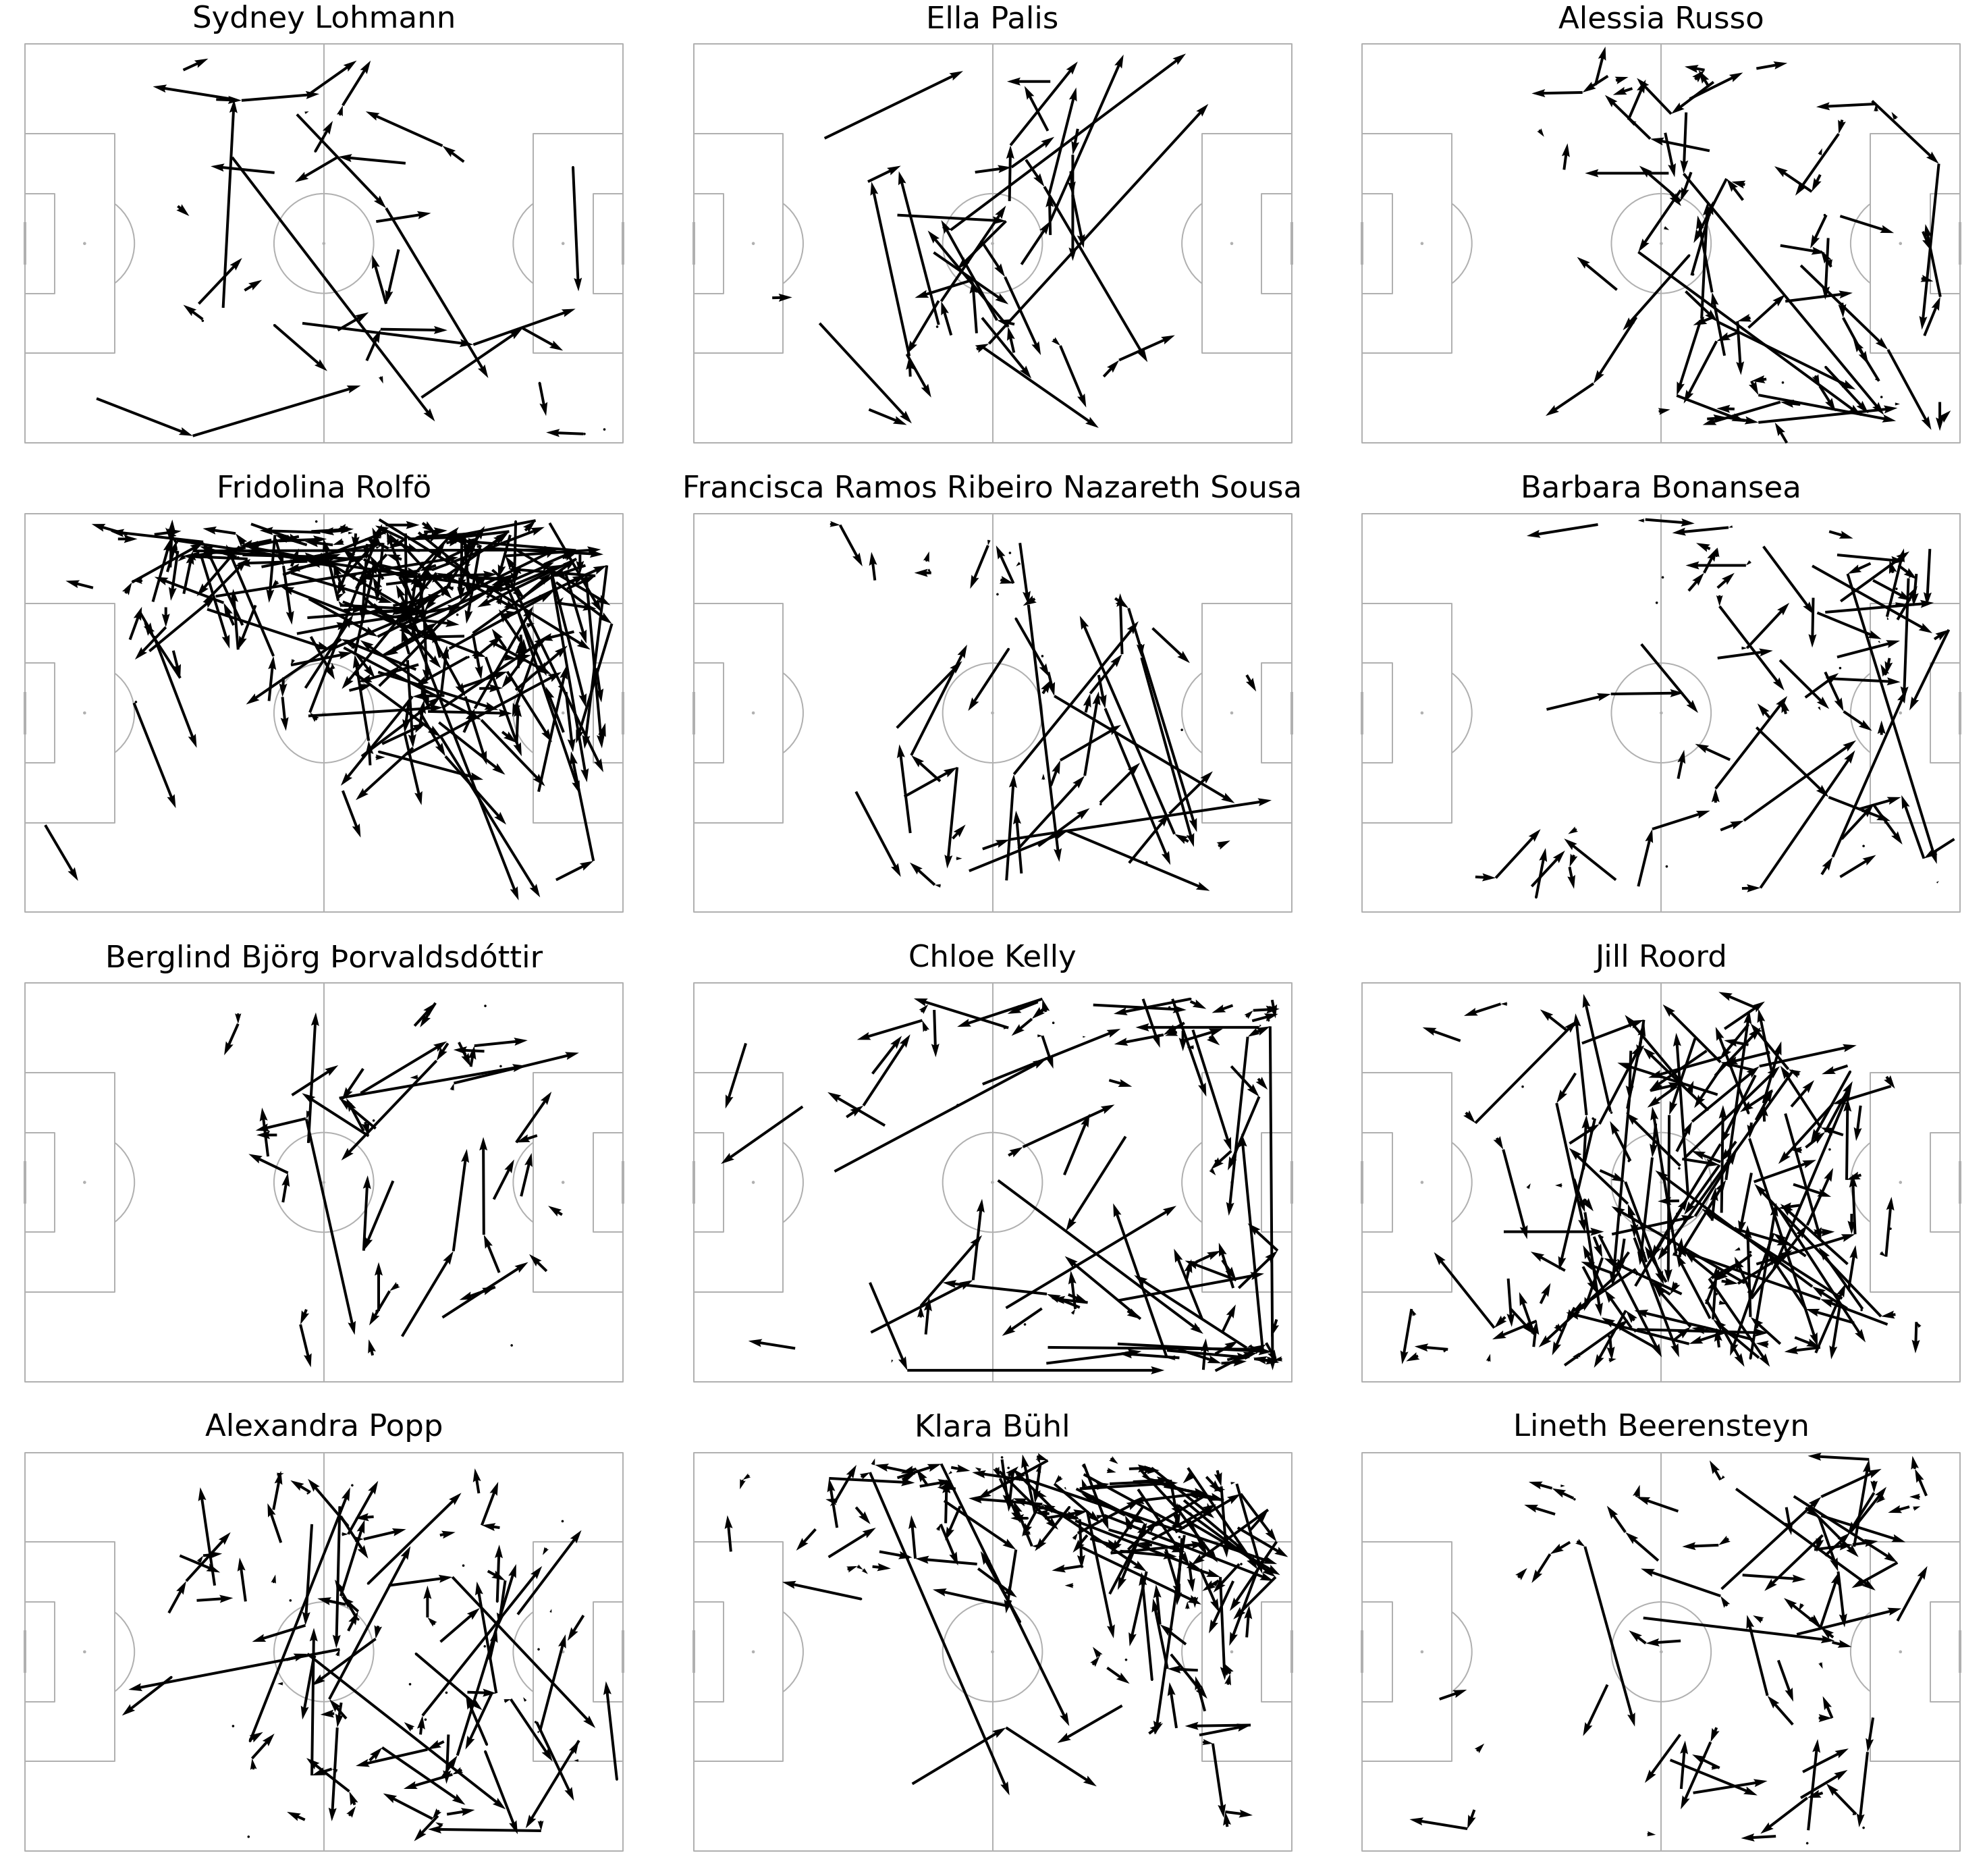

In [29]:

fig, axs = pitch.grid(ncols=3, nrows=4, endnote_height=0, title_height=0, figheight=40, grid_height=0.95, grid_width=0.95)

for idx, player_name in enumerate(player_transitions.head(12).index):
    player = event[event.player_name == player_name]
    pitch.arrows(player.x, player.y, player.end_x, player.end_y, ax=axs.flat[idx])
    axs.flat[idx].text(60, -5, player_name, va='center', ha='center', fontsize=45)